In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from fbprophet import Prophet
import altair as alt
import glob 

#print("5 :: middle is shorter in time in both eyes, initial peak maybe for the new task")
#print("6 :: Hight peak in left eye on third and last spike, nothing on right")
#print("8 :: major peak in the middle. both eyes. Even a negative value")
#print("9 :: ????")
#print("10 :: right spike at the end, left spike in the middle")
#print("11 :: a lot of spikes at random. mostly left eye")
#print("12 :: major spike in the middle, left eye. Right eye almost negative (lower than mean)")
#print("13 :: ????")
#print("14 :: major right spike in the middle, major left spikes at the begin and at the end")
#print("15 :: major left spike at the begin")

alt.renderers.enable('notebook')
pd.options.mode.chained_assignment = None  # default='warn'

annotations_in_temp = "data/annotations/s{}.csv"
tobii_in_temp = "data/tobii/s{}.csv"
subject_cards_file = "data/cards.csv"
features_out = "data/features.csv"
figures_out = "data/figures/ts/{}.jpg"


In [2]:
def clearFloats(x):
    if(type(x) == str):
        x = x.replace('\U00002013', '-').replace(',', '.')
    return x

In [3]:
def preprocessEye(eye_file):
    # read the eye file
    df = pd.read_csv(eye_file, encoding='utf-16', sep='\t')
    
    # rename columns
    df.columns = ['timestamp','prj_name','exp_date','name','rec_name','rec_date','start_time','duration',
                  'rec_fix_filter_name','event','event_val','gaze_x','gaze_y','gaze_3d_x','gaze_3d_y','gaze_3d_z',
                  'gaze_dir_right_x','gaze_dir_right_y','gaze_dir_right_z','gaze_dir_left_x','gaze_dir_left_y',
                  'gaze_dir_left_z','pupil_pos_left_x','pupil_pos_left_y','pupil_pos_left_y',
                  'pupil_pos_right_x','pupil_pos_right_y','pupil_pos_right_z','diam_left', 'diam_right',
                  'rec_media_name', 'rec_media_width', 'rec_media_heigh',
                  'move_type','event_dur','move_type_id','fix_x','fix_y',
                  'gyro_x','gyro_y', 'gyro_z','acc_x', 'acc_y', 'acc_z',
                  'ID']
        
    # remove useless columns
    df = df.drop(['ID','prj_name','exp_date', 'rec_name', 'duration', 'rec_fix_filter_name',
                 'rec_media_name', 'rec_media_width', 'rec_media_heigh',
                 'gyro_x','gyro_y', 'gyro_z','acc_x', 'acc_y', 'acc_z'], axis=1)
    
    # remove useless events
    df = df[df.move_type != "EyesNotFound"]
    df = df[df.event != "RecordingStart"]
    df = df[df.event != "RecordingEnd"]
    df = df[df.event != "SyncPortOutHigh"]
    df = df[df.event != "SyncPortOutLow"]
    df = df.drop(['event', 'event_val'], axis=1)
    
    # set datatypes
    df = df.applymap(clearFloats)
    dfe = df.apply(pd.to_numeric, errors='ignore')
    
    #dfe['dt_index'] = pd.to_datetime(dfe['rec_date'] + ' ' + dfe['start_time'], \
    #                                 format="%d/%m/%Y %H:%M:%S.%f") + \
    #                                pd.to_timedelta(dfe['timestamp'], unit='ms')
    
    dfe['dt_index'] = pd.to_datetime(dfe['start_time'], \
                                     format="%H:%M:%S.%f") + \
                                    pd.to_timedelta(dfe['timestamp'], unit='ms')
    
    dfe = dfe.set_index(pd.DatetimeIndex(dfe['dt_index']))
    
    return dfe

In [4]:
def preprocessAnnotations(annotation_file, card_names):
    # read the eye file
    annot = pd.read_csv(annotation_file, sep='\t', names=['tire', 'remove', 'start', 'stop', 'duration', 'class'])
    annot = annot.drop(['remove'], axis=1)
    annot['show_order'] = annot.index
    
    annot['start_ms'] = annot['start'].apply(stringToMSec)
    annot['stop_ms'] = annot['stop'].apply(stringToMSec)
    annot['duration_ms'] = annot['duration'].apply(stringToMSec)
    
    # DON'T WORK!!
    # convert timestamps
    #start_time_dt = pd.to_datetime(start_time, format="%H:%M:%S.%f")
    #annot['start_dt'] = start_time_dt + pd.to_timedelta(annot['start'].apply(stringToMSec), unit='ms')
    #annot['stop_dt'] = start_time_dt + pd.to_timedelta(annot['stop'].apply(stringToMSec), unit='ms')
    #annot['duration_dt'] = pd.to_timedelta(annot['duration'].apply(stringToMSec), unit='ms')
    
    annot = annot.drop(['start', 'stop', 'duration'], axis=1)
    default = annot.loc[annot['tire'] == "default"]
    
    dfs = [default]
    
    for card in card_names:
        dfs.append(
            annot.loc[(annot['tire'] == "per_card") & (annot['class'] == card)]
        )
        
    return dfs

In [5]:
def stringToMSec(time):
    h, m, sms = time.split(':')
    s, ms = sms.split('.')
    return 1000 * (int(h)*3600 + int(m)*60 + int(s)) + int(ms)

def normalize(df, column):
    max_value = df[column].max()
    min_value = df[column].min()
    df.loc[:, column] = (df[column] - min_value) / (max_value - min_value)
    
    return df


In [6]:
def filterEyeData(eyeDF, annot):
    annot = annot.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'stop_ms']
    
    novelty = eyeDF.loc[(eyeDF['timestamp'] >= start) & (eyeDF['timestamp'] <= stop)]
    
    # RESAMPLE
    #novelty['diam_right'] = pd.DataFrame(novelty['diam_right'].resample("ms").mean().fillna(method='bfill'))
    #novelty['diam_left'] = pd.DataFrame(novelty['diam_left'].resample("ms").mean().fillna(method='bfill'))
    
    # Normalize usefull data
    #novelty = normalize(novelty, 'diam_right')
    #novelty = normalize(novelty, 'diam_left')

    return novelty


def filterShortEyeResponse(eyeDF, annot, ms_after=1500):
    annot = annot.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'stop_ms']    
    short_stop = start + ms_after #look to a window of 1.5 seconds after the stimulus
    
    short_stop = min(short_stop, stop)    
    short_response = eyeDF.loc[(eyeDF['timestamp'] >= start) & (eyeDF['timestamp'] <= short_stop)]

    return short_response

def filterBaseline(eyeDF, overall, ms_before=1500):
    annot = overall.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'start_ms']
    
    early_start = start - ms_before #look to a window of 1.5 seconds before the overall stimulus
    
    #print(early_start)
    #print(stop)
    
    baseline = eyeDF.loc[(eyeDF['timestamp'] >= early_start) & (eyeDF['timestamp'] <= stop)]

    return baseline


In [7]:
def loadTimeSeries(subject, card_names,
                   tobbi_input_template=tobii_in_temp,
                   annot_input_template=annotations_in_temp,
                   short_response_dur=1500):
    
    print("LOAD s{}".format(subject))
    
    f_in = tobbi_input_template.format(subject)
    annot_in = annot_input_template.format(subject)
    
    # vector with temporal filtered data for each card
    cards = []
    cards_short_response = []
    
    # load topii data
    eye = preprocessEye(f_in.format(subject))
    
    # load novelty annotations
    annotations = preprocessAnnotations(
        annot_in.format(subject), card_names)
    
    # filter eye data relative to overall novelty phase
    overall = filterEyeData(eye, annotations[0])
    
    # filter the baseline to rescale the pupil dilation data
    baseline = filterBaseline(eye, annotations[0], ms_before=5000)
    
    # single cards eye data overall and in the 1.5 sec after the stimulus
    for i in range(1, len(annotations)):
        c = filterEyeData(eye, annotations[i])
        c_short = filterShortEyeResponse(eye, annotations[i], ms_after=short_response_dur)
        c['class'] = annotations[i]['class'].iloc[0]
        cards.append(c)
        cards_short_response.append(c_short)
    
    return eye, annotations, baseline, overall, cards, cards_short_response

In [8]:
def getSubjectCard(subject, cards_file=subject_cards_file):
    s_cards = pd.read_csv(cards_file, sep=';')
    sub_name = "s" + str(subject)
    
    #print(sub_name)
    
    card = s_cards.loc[s_cards['subject'] == sub_name]
    return card['card'].values[0]

def plotPupilDilationTimeSeries(subject, card_names, overall_eye, cards_eye,
                                subj_card_in=subject_cards_file):
    
    colors = ['green', 'yellow', 'red', 'purple', 'grey', 'pink']
    cards_plot_features = []
    
    for i in range(0, len(cards_eye)):    
        cards_plot_features.append([
            cards_eye[i]['timestamp'].min(),
            cards_eye[i]['timestamp'].max(),
            card_names[i]
        ])    
        
    cards_plot_features.sort()    
    sub_card = getSubjectCard(subject, subj_card_in)
    
    fig, ass = plt.subplots(2, figsize=(15, 6), sharex=True)
    
    ass[0].set_title("RIGHT {}".format(subject))
    ass[1].set_title("LEFT {}".format(subject))
    #ass[2].set_title("BOTH")
    
    ass[0].scatter(overall_eye['timestamp'],overall_eye['diam_right'], s=2, c='r')
    ass[1].scatter(overall_eye['timestamp'],overall_eye['diam_left'], s=2, c='b')
    #ass[2].scatter(overall_eye['timestamp'],overall_eye['diam_right'], s=2, c='r')
    #ass[2].scatter(overall_eye['timestamp'],overall_eye['diam_left'], s=2, c='b')
    
    
    #ass[0].plot(overall_eye['diam_right'], c='black')
    #ass[1].plot(overall_eye['diam_left'], c='black')
    #ass[2].plot(overall_eye['diam_right'])
    #ass[2].plot(overall_eye['diam_left'])

    for i in range(0, len(cards_eye)):    
        alp = 0.2
        color = 'green'
        if(cards_plot_features[i][2] == sub_card):
            alp = 0.3
            color = 'yellow'
            
        ass[0].axvspan(cards_plot_features[i][0],
                       cards_plot_features[i][1],
                       linewidth=1, color=color, alpha=alp)
        
        ass[1].axvspan(cards_plot_features[i][0],
                       cards_plot_features[i][1],
                       linewidth=1, color=color, alpha=alp)
        
        #ass[2].axvspan(cards_plot_features[i][0],
        #               cards_plot_features[i][1],
        #               linewidth=1, color=color, alpha=alp)
    
    #plt.show()    
    return fig

LOAD s7


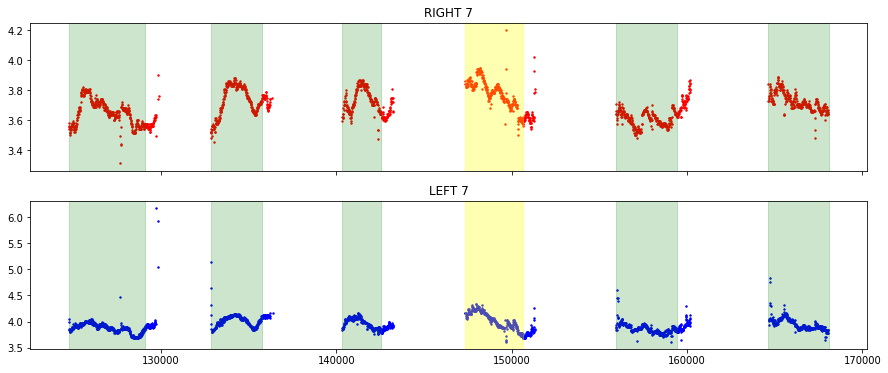

In [9]:
subject = 7
card_names = ['unicorn', 'pepper', 'minion', 'pig', 'hedge', 'aliens']

eye_df, annot_dfs, baseline, overall_eye_df, cards_eye_dfs, cards_eye_short_response_dfs = \
                                                                    loadTimeSeries(subject, card_names)
subject_card = getSubjectCard(subject, subject_cards_file)
fig = plotPupilDilationTimeSeries(subject, card_names, overall_eye_df, cards_eye_dfs)
#print(subject_card)

In [10]:
class SubjectMagicFeatures:
    
    def __init__(self,
                 subject,
                 subject_card,
                 annot_dfs,
                 card_eye_dfs,
                 card_eye_short_resp_dfs,
                 short_resp_duration_ms,
                 cols,
                 refer_to_baseline=False,
                 baseline=None,
                 refer_method='sub'):
        
        # ==== CALCULATE THE BASELINE =============
        if(refer_to_baseline):            
            self.base_right_mean = baseline['diam_right'].mean(skipna = True)
            self.base_left_mean = baseline['diam_left'].mean(skipna = True)     
            
        self.features = pd.DataFrame(columns=cols)
        
        # Process Each card and compose the dataframe
        for c in range(0, len(card_eye_dfs)):
                   
            # ==== TASK FEATURES =============
            
            self.subject = subject
            self.duration = annot_dfs[c+1]['duration_ms'].iloc[0]
            self.card_class = cards_eye_dfs[c]['class'].iloc[0]
            
            if(self.card_class == subject_card):
                self.is_subject_one = 1
            else:
                self.is_subject_one = 0
                
            self.show_order = annot_dfs[c+1]['show_order'].iloc[0]        
        
            # ==== EXTRACT CARD ==========
            
            card = cards_eye_dfs[c][['diam_right', 'diam_left', 'move_type']]
            sr_card = card_eye_short_resp_dfs[c][['diam_right', 'diam_left', 'move_type']]        
        
            # ==== EVENTS =============
            
            move_types = card[['move_type']]
            move_types['count'] = 1
            move_types = move_types.groupby('move_type').count()
            
            fix_num = move_types.loc[move_types.index == "Fixation"]
            sacc_num = move_types.loc[move_types.index == "Saccade"]
            
            # Check if not empty
            if not fix_num.empty:
                fix_num = fix_num.iloc[0][0]
            else:
                fix_num = 0
                
            if not sacc_num.empty:
                sacc_num = sacc_num.iloc[0][0]
            else:
                sacc_num = 0
            
            #fix_num = move_types.loc[move_types.index == "Fixation"].iloc[0][0]
            #sacc_num = move_types.loc[move_types.index == "Saccade"].iloc[0][0]
            
            duration_sec = self.duration / 1000
            
            self.fix_freq = fix_num / duration_sec
            self.sacc_freq = sacc_num / duration_sec
            
            # ==== EVENTS SHORT RESPONSE =============
            
            sr_move_types = sr_card[['move_type']]
            sr_move_types['count'] = 1
            sr_move_types = sr_move_types.groupby('move_type').count()
            
            sr_fix_num = move_types.loc[sr_move_types.index == "Fixation"]
            sr_sacc_num = move_types.loc[sr_move_types.index == "Saccade"]
            
            # Check if not empty
            if not sr_fix_num.empty:
                sr_fix_num = sr_fix_num.iloc[0][0]
            else:
                sr_fix_num = 0
                
            if not sr_sacc_num.empty:
                sr_sacc_num = sr_sacc_num.iloc[0][0]
            else:
                sr_sacc_num = 0
            
            
            #sr_fix_num = sr_move_types.loc[sr_move_types.index == "Fixation"].iloc[0][0]
            #sr_sacc_num = sr_move_types.loc[sr_move_types.index == "Saccade"].iloc[0][0]
            
            sr_duration_sec = short_resp_duration_ms / 1000
            
            self.sr_fix_freq = sr_fix_num / sr_duration_sec
            self.sr_sacc_freq = sr_sacc_num / sr_duration_sec

            # ==== RESCALE DATA TO BASELINE =============
            
            if(refer_to_baseline):
                if(refer_method == 'sub'):
                    card['diam_right'] = card['diam_right'] - self.base_right_mean
                    card['diam_left'] = card['diam_left'] - self.base_left_mean
                    
                if(refer_method == 'div'):
                    card['diam_right'] = card['diam_right'] / self.base_right_mean
                    card['diam_left'] = card['diam_left'] / self.base_left_mean
                
            # ==== SINGLE CARD PUPIL FEATURES =============
           
            # RIGHT PUPIL
            self.pupil_diam_right_mean = card['diam_right'].mean(skipna = True)
            self.pupil_diam_right_std = card['diam_right'].std(skipna = True)
            self.pupil_diam_right_min = card['diam_right'].min(skipna = True)
            self.pupil_diam_right_max = card['diam_right'].max(skipna = True)
            
            # LEFT PUPIL            
            self.pupil_diam_left_mean = card['diam_left'].mean(skipna = True)
            self.pupil_diam_left_std = card['diam_left'].std(skipna = True)
            self.pupil_diam_left_min = card['diam_left'].min(skipna = True)
            self.pupil_diam_left_max = card['diam_left'].max(skipna = True)

            # ==== SINGLE CARD SHORT RESPONSE PUPIL FEATURES =============
            
            # RIGHT PUPIL
            self.sr_pupil_diam_right_mean = sr_card['diam_right'].mean(skipna = True)
            self.sr_pupil_diam_right_std = sr_card['diam_right'].std(skipna = True)
            self.sr_pupil_diam_right_min = sr_card['diam_right'].min(skipna = True)
            self.sr_pupil_diam_right_max = sr_card['diam_right'].max(skipna = True)
            
            # LEFT PUPIL            
            self.sr_pupil_diam_left_mean = sr_card['diam_left'].mean(skipna = True)
            self.sr_pupil_diam_left_std = sr_card['diam_left'].std(skipna = True)
            self.sr_pupil_diam_left_min = sr_card['diam_left'].min(skipna = True)
            self.sr_pupil_diam_left_max = sr_card['diam_left'].max(skipna = True)

            self.column_names = cols            
            self.features = self.features.append(self.aggregate(), ignore_index=True)

    def getDataFrame(self):
        return self.features
    
    def aggregate(self):
        return pd.DataFrame(
            data=[[
                self.subject,
                self.duration,
                self.card_class,
                self.show_order,
                self.fix_freq,
                self.sacc_freq,
                self.sr_fix_freq,
                self.sr_sacc_freq,
                self.pupil_diam_right_mean,
                self.pupil_diam_right_std,
                self.pupil_diam_right_min,
                self.pupil_diam_right_max,
                self.pupil_diam_left_mean,
                self.pupil_diam_left_std,
                self.pupil_diam_left_min,
                self.pupil_diam_left_max,
                self.sr_pupil_diam_right_mean,
                self.sr_pupil_diam_right_std,
                self.sr_pupil_diam_right_min,
                self.sr_pupil_diam_right_max,
                self.sr_pupil_diam_left_mean,
                self.sr_pupil_diam_left_std,
                self.sr_pupil_diam_left_min,
                self.sr_pupil_diam_left_max,
                self.is_subject_one,
            ]],
            columns=self.column_names
        )        

In [11]:
def extractMinSubjectSet(path):
    filenames = glob.glob(path.format("*"))
    
    subjects = []
    
    for fn in filenames:
        id =fn.split("/")[-1].split(".")[0].replace('s', '')
        subjects.append(int(id))
    
    return subjects
    

LOAD s4
LOAD s5
LOAD s6
LOAD s7
LOAD s8
LOAD s10
LOAD s11
LOAD s12
LOAD s13
LOAD s14
LOAD s15
LOAD s16
LOAD s18
LOAD s20
LOAD s21
LOAD s22
LOAD s25


,subject,duration,card_class,show_order,fix_freq,sacc_freq,sr_fix_freq,sr_sacc_freq,pupil_diam_right_mean,pupil_diam_right_std,...,pupil_diam_left_max,sr_pupil_diam_right_mean,sr_pupil_diam_right_std,sr_pupil_diam_right_min,sr_pupil_diam_right_max,sr_pupil_diam_left_mean,sr_pupil_diam_left_std,sr_pupil_diam_left_min,sr_pupil_diam_left_max,label
0,4,2783,unicorn,1,70.427596,112.468559,130.666667,208.666667,0.988358,0.058228,...,1.462055,4.104038,0.137908,3.70,4.42,4.540104,0.467834,3.96,6.80,1
1,4,2383,pepper,4,152.748636,51.195971,242.666667,81.333333,0.883964,0.035747,...,1.180394,3.706321,0.116262,3.24,3.97,3.979074,0.325584,3.33,5.49,0
2,4,2368,minion,5,97.128378,82.347973,153.333333,130.000000,0.887650,0.072638,...,1.395402,3.710982,0.364046,2.90,6.50,4.079825,0.496308,3.51,6.31,0
3,4,2349,pig,2,108.556833,76.628352,170.000000,120.000000,0.958309,0.047231,...,1.330900,3.974083,0.100231,3.73,4.19,4.375091,0.321569,3.97,6.19,0
4,4,2126,hedge,3,95.014111,66.792098,134.666667,94.666667,0.895370,0.059216,...,1.268548,3.764359,0.114292,3.42,4.34,4.115773,0.294759,3.66,5.69,0
5,4,3228,aliens,6,101.610905,83.952912,218.666667,180.666667,0.912749,0.050083,...,1.178244,3.842360,0.119469,3.22,4.04,4.112364,0.270069,3.61,5.30,0
6,5,2808,unicorn,4,141.025641,1.068376,264.000000,0.000000,0.980780,0.015647,...,1.140908,3.103333,0.023094,3.06,3.14,2.971538,0.053205,2.88,3.04,0
7,5,2197,pepper,6,190.714611,13.199818,279.333333,19.333333,0.928338,0.016986,...,0.955981,3.008625,0.069296,2.78,3.19,2.906951,0.071036,2.64,3.01,0
8,5,2480,minion,5,133.467742,3.629032,220.666667,0.000000,0.975806,0.017853,...,1.018668,3.118500,0.075273,2.95,3.30,3.082400,0.107443,2.84,3.24,0
9,5,2945,pig,1,197.283531,17.317487,387.333333,34.000000,1.032119,0.036931,...,1.423001,3.263333,0.111007,3.02,3.49,3.268810,0.337319,2.98,4.54,1


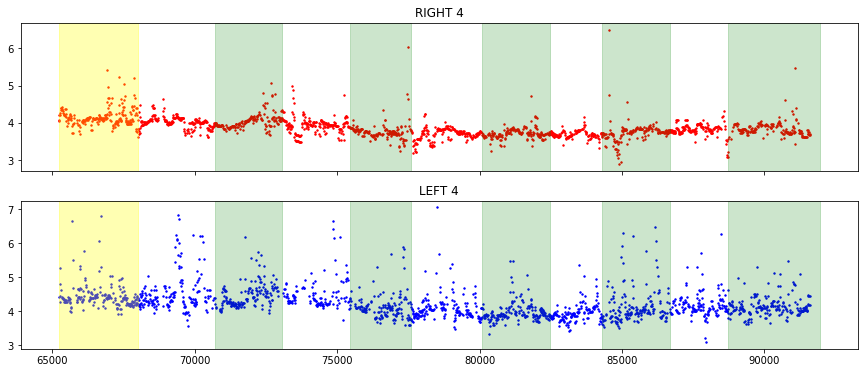

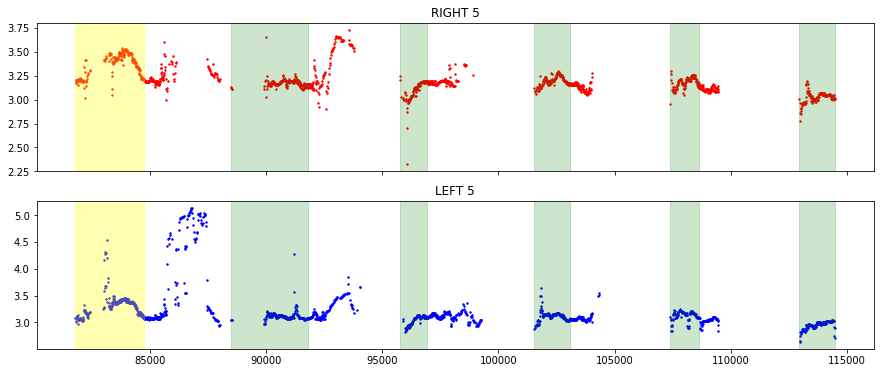

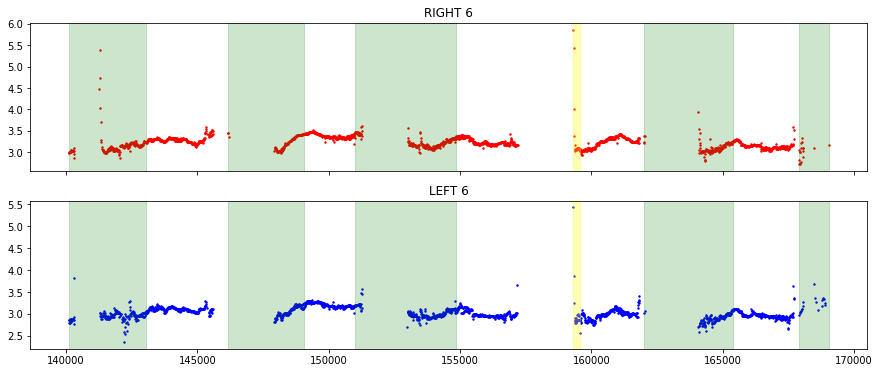

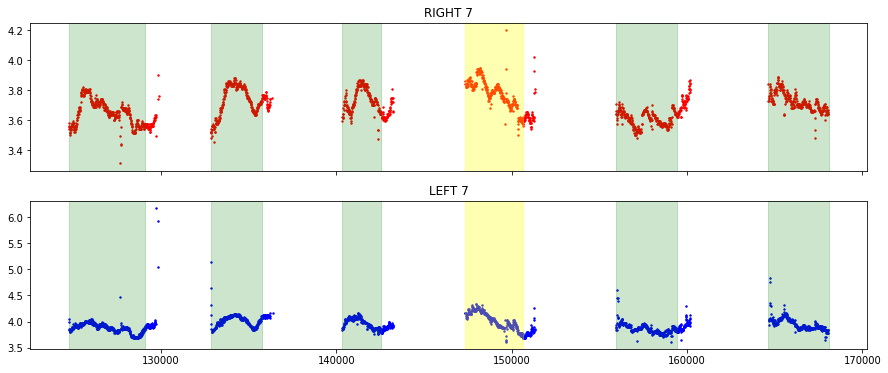

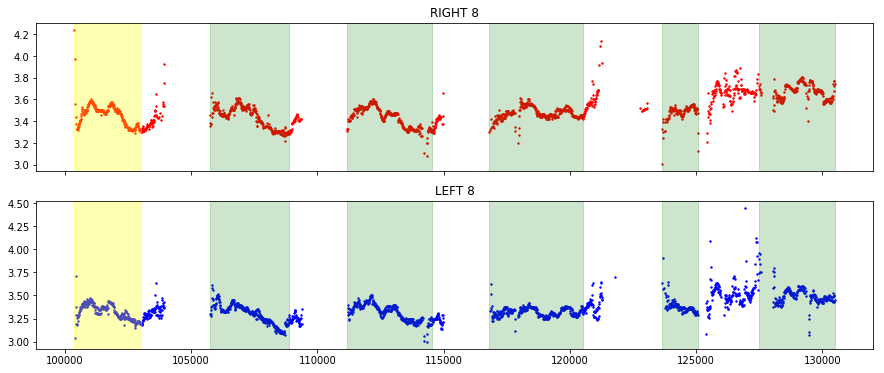

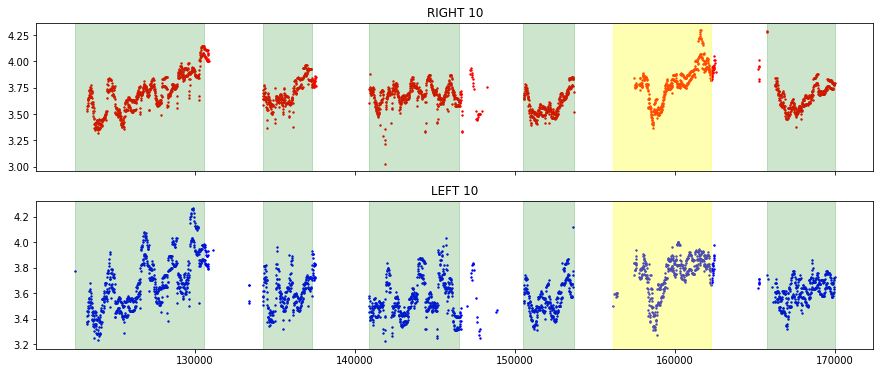

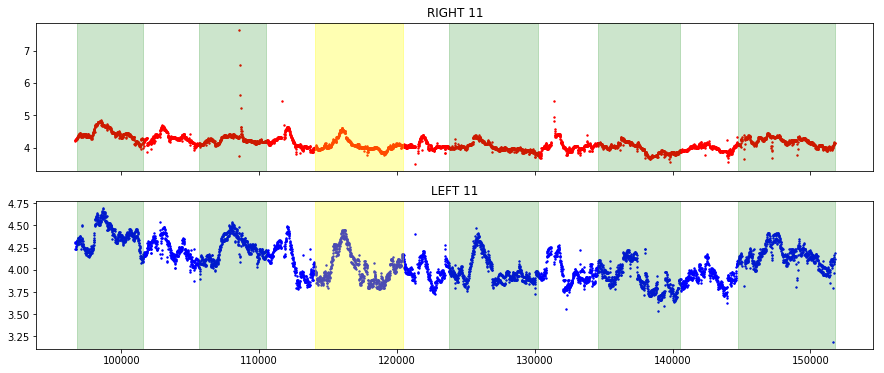

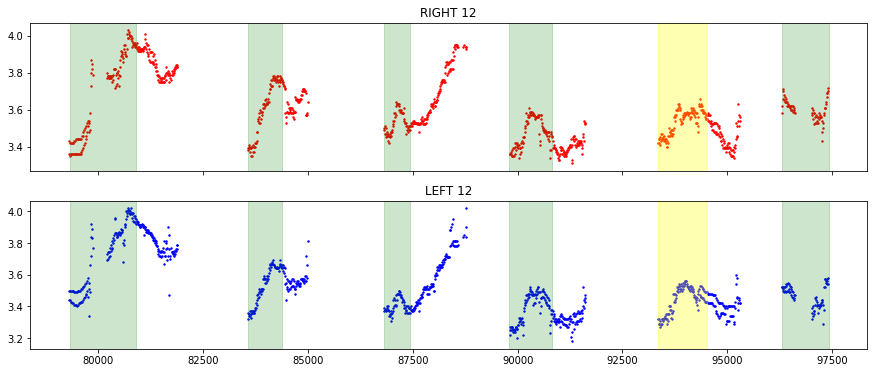

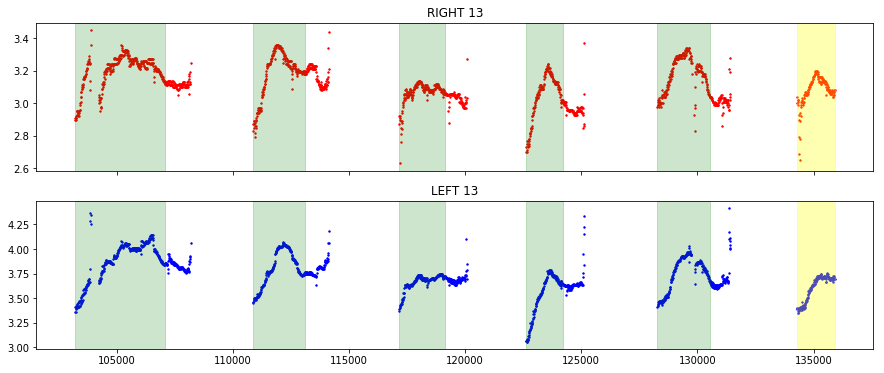

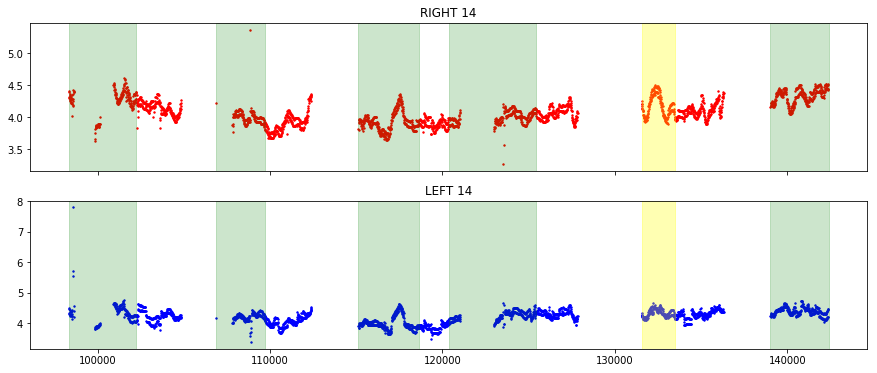

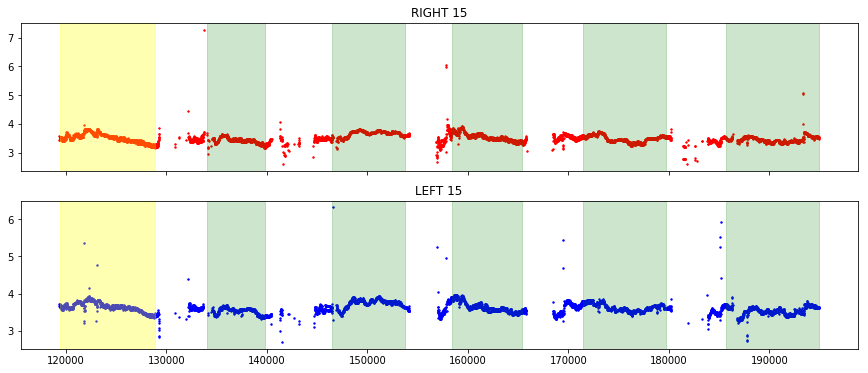

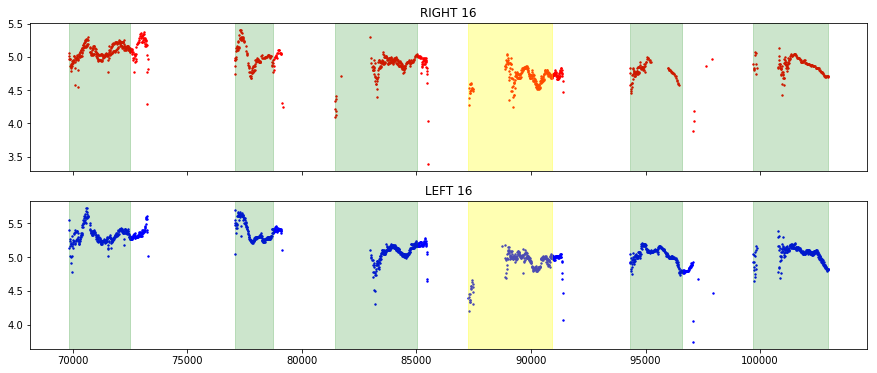

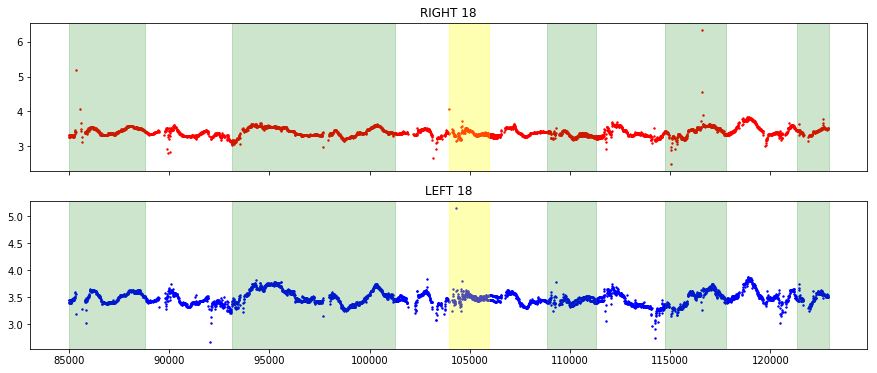

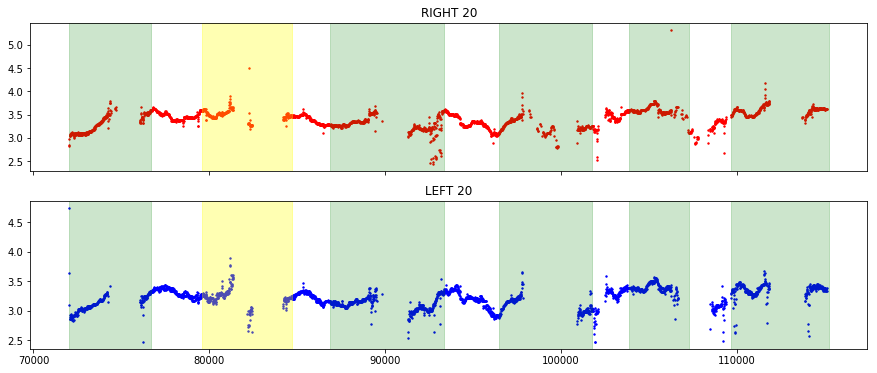

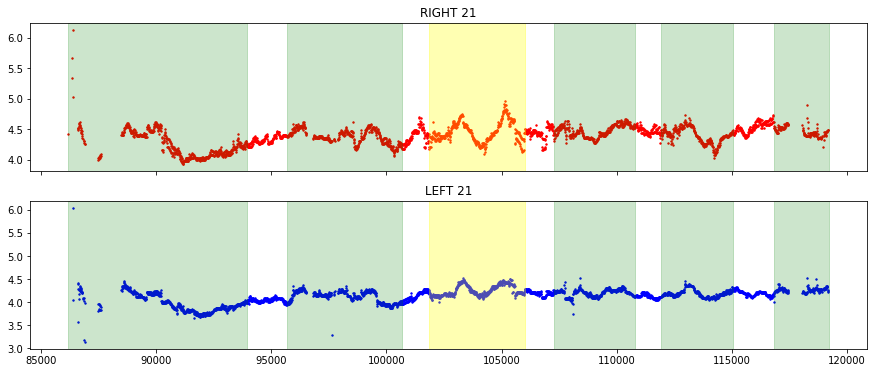

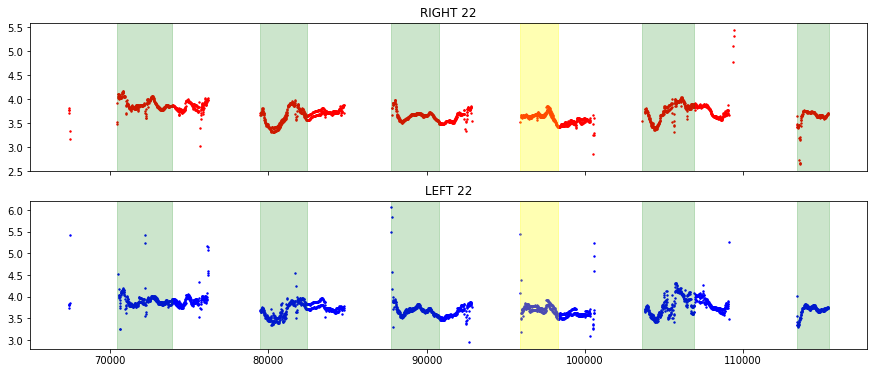

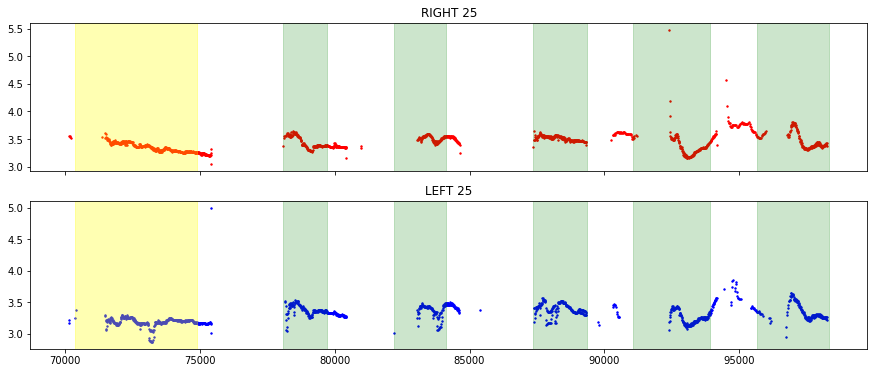

In [12]:
annot_subs = extractMinSubjectSet(annotations_in_temp)
eye_subs = extractMinSubjectSet(tobii_in_temp)

subjects = [s for s in eye_subs if s in annot_subs]
subjects.sort()

column_names = [
        'subject','duration','card_class','show_order',
        'fix_freq','sacc_freq','sr_fix_freq','sr_sacc_freq',
        'pupil_diam_right_mean','pupil_diam_right_std','pupil_diam_right_min','pupil_diam_right_max',
        'pupil_diam_left_mean','pupil_diam_left_std','pupil_diam_left_min','pupil_diam_left_max',
        'sr_pupil_diam_right_mean','sr_pupil_diam_right_std','sr_pupil_diam_right_min','sr_pupil_diam_right_max',
        'sr_pupil_diam_left_mean','sr_pupil_diam_left_std','sr_pupil_diam_left_min','sr_pupil_diam_left_max',
        'label'
    ]

short_response_dur = 1500
    
features = pd.DataFrame(columns=column_names)
card_names = ['unicorn', 'pepper', 'minion', 'pig', 'hedge', 'aliens']


for sub in subjects:
    eye_df, annot_dfs, baseline, overall_eye_df, cards_eye_dfs, cards_eye_short_response_dfs = \
                                                                        loadTimeSeries(sub, card_names)
    subject_card = getSubjectCard(sub, subject_cards_file)   
    mf = SubjectMagicFeatures(sub, subject_card,
                              annot_dfs,
                              cards_eye_dfs, cards_eye_short_response_dfs,
                              short_response_dur,
                              cols=column_names,
                              refer_to_baseline=True,
                              baseline=baseline,
                              refer_method='div')
    
    features = features.append(mf.getDataFrame(), ignore_index=True)
    figure = plotPupilDilationTimeSeries(sub, card_names, overall_eye_df, cards_eye_dfs)
    figure.savefig(figures_out.format(sub))

features.to_csv(features_out, columns=column_names, sep='\t', index=False)
features
